In [1]:
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from datetime import datetime
import pyart
import numpy as np
import wradlib as wrl
import glob, os


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


In [2]:
files = sorted(glob.glob("R*nc"))

In [3]:
def CAPPI(file = None, fields = ["DBZ", "VEL", "PHIDP", "ZDR"], save_data=False, path = './'):
    new_vol = wrl.io.open_cfradial2_dataset(file)
    # Iterate over sweeps and process
    swp_list = []
    for v in new_vol:
        # georeference and stack dimensions
        swp = v.pipe(wrl.georef.georeference_dataset).stack(points=["azimuth", "range"])
        swp_list.append(swp)

    # concat sweeps to volume
    vol0 = xr.concat(swp_list, dim="points")

    # Create XYZ Coordinate DataArray
    xyz = xr.concat([vol0.x, vol0.y, vol0.z], dim="xyz").transpose()

    # Create Target 3D Grid, choose your wanted resolution
    xcnt = 500
    ycnt = 500
    zcnt = 100
    trgx = np.linspace(xyz[:, 0].min(),xyz[:, 0].max(), xcnt)
    trgy = np.linspace(xyz[:, 1].min(),xyz[:, 1].max(), ycnt)
    trgz = np.linspace(0, 20000, zcnt)
    yy, hh, xx = np.meshgrid(trgy,trgz,trgx)
    trgxyz = np.stack([xx.flatten(), yy.flatten(), hh.flatten()]).T

    # Create Gridder/Interpolator
    trgshape=xx.shape
    gridder = wrl.vpr.CAPPI(polcoords=xyz,
                            gridcoords=trgxyz,
                            gridshape=trgshape,
                            maxrange=vol0.range.values.max(),
                            minelev=0,
                            maxelev=vol0.fixed_angle.values.max(),
                            ipclass=wrl.ipol.Nearest)
    # Interpolate Data into 3D Grid
    trgx = trgxyz[:, 0].reshape(trgshape)[0, 0, :]
    trgy = trgxyz[:, 1].reshape(trgshape)[0, :, 0]
    trgz = trgxyz[:, 2].reshape(trgshape)[:, 0, 0]
    latlon = pyart.core.cartesian_to_geographic_aeqd(trgx, trgy, 
                                                     lon_0=vol0.longitude.data, 
                                                     lat_0=vol0.latitude.data)
    lat = latlon[1]
    lon = latlon[0]
    for field in fields:
        varname = np.ma.masked_invalid(gridder(vol0[field].values)).reshape(trgshape)
        ds = xr.Dataset(
        data_vars=
        {
            field:(["z", "y", "x"], varname),
        },
        coords={
            "x": (["x"], trgx),
            "y": (["y"], trgy),
            "z": (["z"], trgz),
            "lat":(lat),
            "lon":(lon),
            "time":(vol0.time.mean())
        },
              )
        if save_data:
            os.makedirs(path, exist_ok=True)
            ds.to_netcdf(path+field+"_"+str(ds.time.dt.strftime("%Y%m%d%H%M%S").data)+".nc")
    return ds
        

In [4]:
files = sorted(glob.glob("R*.nc"))
files

['RCTLS_30NOV2017_000100_L2B_STD.nc']

In [5]:
for file in files:
    CAPPI(file=file, fields=['DBZ', 'VEL', 'PHIDP', 'ZDR'], save_data=True, path="gridded_data/")

/Users/syed44/miniconda3/envs/dda/lib/python3.10/site-packages/wradlib/vpr.py:103: DeprecationWarning: ``gridshape`` is not used in <class 'wradlib.vpr.CAPPI'>. It will be removed in wradlib version 2.0.
  warnings.warn(


In [6]:
!ls gridded_data

DBZ_20171130000420.nc   VEL_20171130000420.nc
PHIDP_20171130000420.nc ZDR_20171130000420.nc


In [7]:
ds = xr.open_mfdataset("gridded_data/*nc")

In [8]:
ds

<xarray.Dataset>
Dimensions:     (z: 100, y: 500, x: 500, lat: 500, lon: 500)
Coordinates:
  * x           (x) float64 -2.398e+05 -2.388e+05 ... 2.388e+05 2.398e+05
  * y           (y) float64 -2.398e+05 -2.388e+05 ... 2.389e+05 2.398e+05
  * z           (z) float64 0.0 202.0 404.0 606.1 ... 1.96e+04 1.98e+04 2e+04
  * lat         (lat) float64 6.375 6.384 6.393 6.401 ... 10.67 10.68 10.69
  * lon         (lon) float64 74.7 74.7 74.71 74.72 ... 79.03 79.04 79.05 79.06
    latitude    float64 8.537
    longitude   float64 76.87
    altitude    float64 100.0
    sweep_mode  <U20 'azimuth surveillance'
    time        datetime64[ns] 2017-11-30T00:04:20
Data variables:
    DBZ         (z, y, x) float64 dask.array<chunksize=(100, 500, 500), meta=np.ndarray>
    PHIDP       (z, y, x) float64 dask.array<chunksize=(100, 500, 500), meta=np.ndarray>
    VEL         (z, y, x) float64 dask.array<chunksize=(100, 500, 500), meta=np.ndarray>
    ZDR         (z, y, x) float64 dask.array<chunksize=(100, 500, 500), meta=np.ndarray>

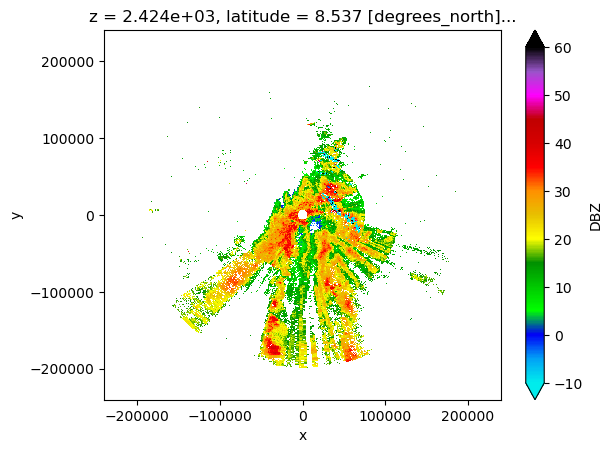

In [15]:
ds["DBZ"].sel(z = 2500, method = "nearest").plot(vmin = -10, vmax = 60, cmap = "pyart_NWSRef")

In [20]:
from matplotlib import pyplot as plt

(0.0, 15000.0)

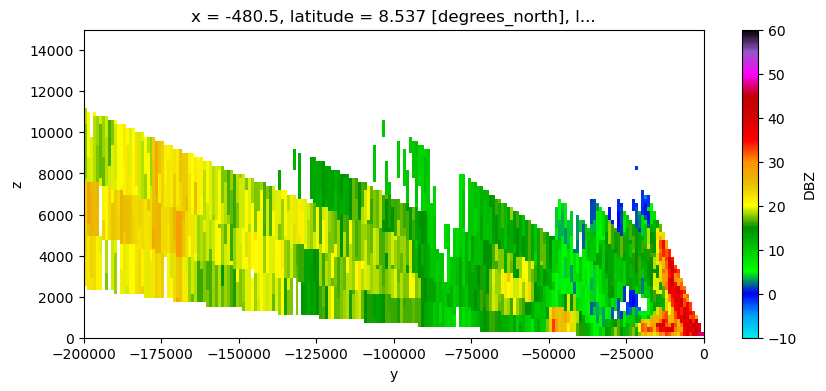

In [30]:
ds['DBZ'].sel(x = 0, method="nearest").plot(vmin = -10, vmax = 60, cmap = "pyart_NWSRef", figsize = [10, 4])
plt.xlim(-20e4, 0)
plt.ylim(0, 15e3)

(0.0, 13000.0)

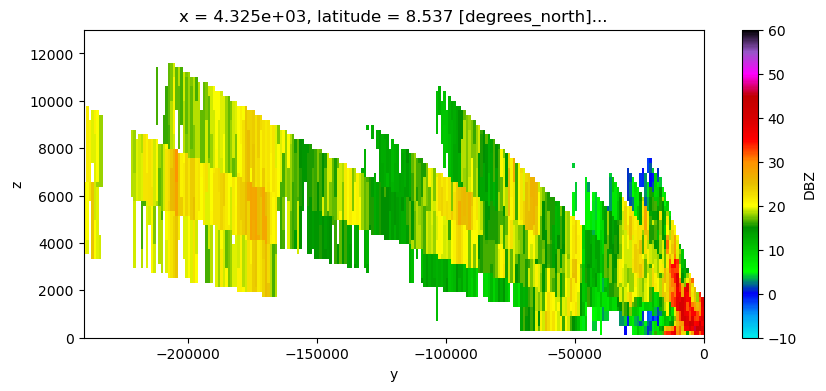

In [31]:
ds['DBZ'].sel(x = 4000, method="nearest").plot(vmin = -10, vmax = 60, cmap = "pyart_NWSRef", figsize = [10, 4])
plt.xlim(None, 0)
plt.ylim(0, 13e3)

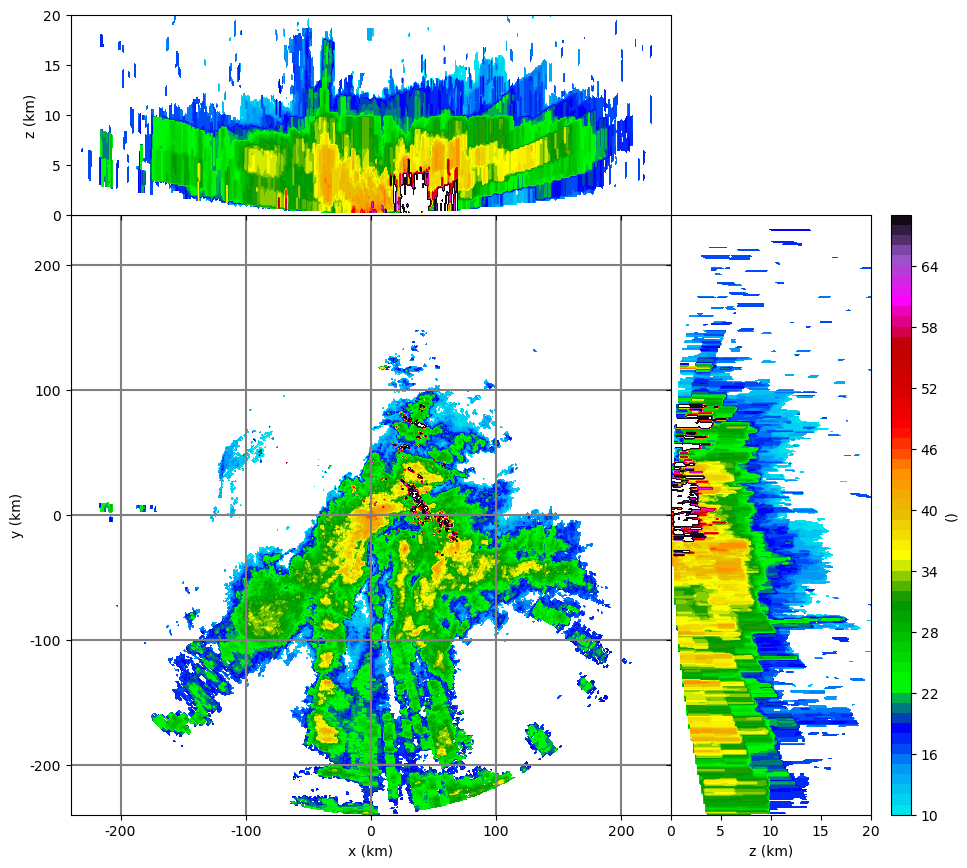

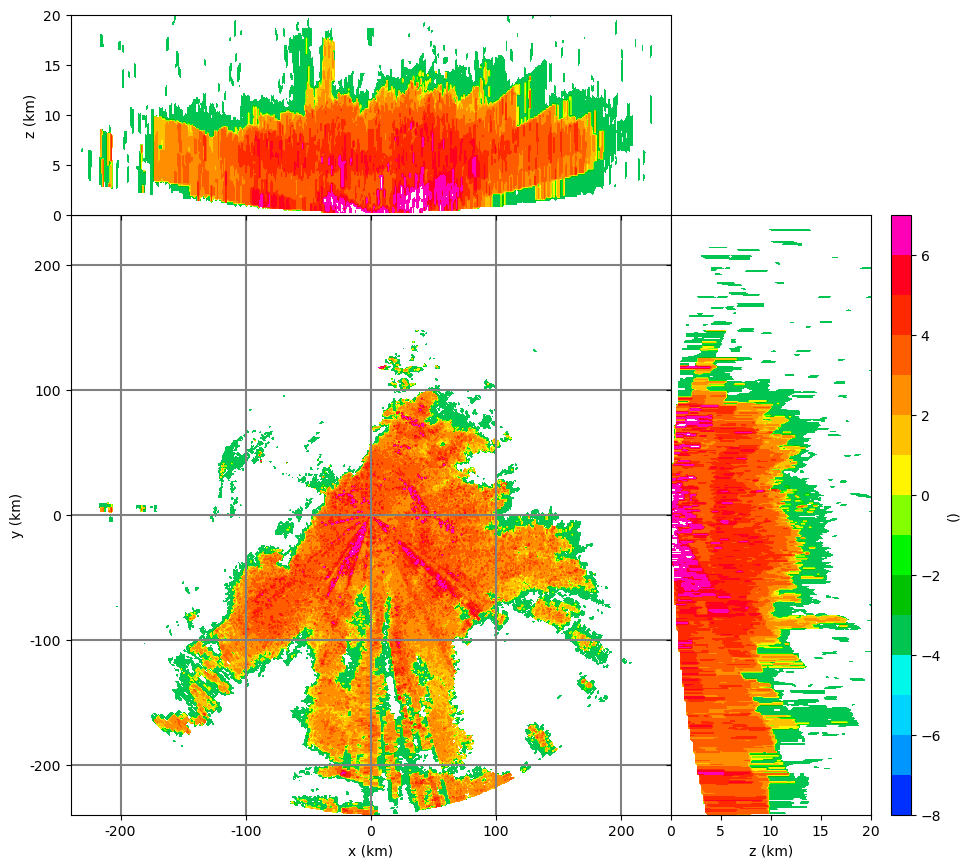

In [43]:
wrl.vis.plot_max_plan_and_vert(ds.x, ds.y, ds.z, ds.DBZ, cmap = "pyart_NWSRef", levels=range(10, 70, 1))
wrl.vis.plot_max_plan_and_vert(ds.x, ds.y, ds.z, ds.ZDR, cmap = pyart.graph.cm.RefDiff, levels=range(-8, 8, 1))